<a href="https://colab.research.google.com/github/efsiul/fruit_sorter_project/blob/master/Luis_Cadavid_Johana_Rios_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow

MobileNet: MobileNet is a small and efficient deep learning model, which is designed for use on mobile devices and low-power devices

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
# Cargar el modelo base de MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Crear entradas con la forma correcta
inputs = Input(shape=(224, 224, 3))

# Pasar las entradas a través del modelo base
x = base_model(inputs, training=False)

# Añadir una capa de pooling global
x = layers.GlobalAveragePooling2D()(x)

# Añadir la capa densa final
outputs = layers.Dense(6, activation='softmax')(x)

# Combinar entradas y salidas para crear el modelo
model = models.Model(inputs, outputs)


In [ ]:
# Mostrar el resumen del modelo
model.summary()

# Compilar el modelo
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 6150      
                                                                 
Total params: 3235014 (12.34 MB)
Trainable params: 6150 (24.02 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [ ]:
# Configurar los generadores de datos
datagen_train = ImageDataGenerator(samplewise_center=True,  # normalizar
    rotation_range=10,  # rotar aleatoriamente
    zoom_range=0.1,  # hacer zoom aleatoriamente
    width_shift_range=0.1,  # desplazar horizontalmente
    height_shift_range=0.1,  # desplazar verticalmente
    horizontal_flip=True,  # voltear horizontalmente
    vertical_flip=True)  # voltear verticalmente

datagen_valid = ImageDataGenerator(samplewise_center=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar y iterar sobre el conjunto de datos de entrenamiento
train_it = datagen_train.flow_from_directory(
    '/content/drive/MyDrive/Udea/Simulación/train',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
)

# Cargar y iterar sobre el conjunto de datos de validación
valid_it = datagen_valid.flow_from_directory(
    '/content/drive/MyDrive/Udea/Simulación/test',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False  # Asegurar que el orden de las imágenes sea el mismo para predicciones y etiquetas
)

Found 9833 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [ ]:
# Entrenar el modelo
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples // train_it.batch_size,
          validation_steps=valid_it.samples // valid_it.batch_size,
          epochs=20)

Epoch 1/20
307/307 [==============================] - 2475s 8s/step - loss: 0.7187 - categorical_accuracy: 0.7366 - val_loss: 0.4163 - val_categorical_accuracy: 0.8534
Epoch 2/20
307/307 [==============================] - 189s 617ms/step - loss: 0.3884 - categorical_accuracy: 0.8572 - val_loss: 0.2970 - val_categorical_accuracy: 0.8925
Epoch 3/20
307/307 [==============================] - 187s 609ms/step - loss: 0.3132 - categorical_accuracy: 0.8838 - val_loss: 0.2639 - val_categorical_accuracy: 0.9062
Epoch 4/20
307/307 [==============================] - 189s 615ms/step - loss: 0.2875 - categorical_accuracy: 0.8952 - val_loss: 0.2511 - val_categorical_accuracy: 0.9085
Epoch 5/20
307/307 [==============================] - 190s 620ms/step - loss: 0.2678 - categorical_accuracy: 0.9031 - val_loss: 0.2835 - val_categorical_accuracy: 0.8914
Epoch 6/20
307/307 [==============================] - 188s 612ms/step - loss: 0.2534 - categorical_accuracy: 0.9073 - val_loss: 0.2632 - val_categorical

In [ ]:
# Evaluar el modelo
model.evaluate(valid_it, steps=valid_it.samples // valid_it.batch_size)

84/84 [==============================] - 23s 271ms/step - loss: 0.1686 - categorical_accuracy: 0.9297


[0.16858169436454773, 0.9296875]

In [ ]:
# Generar predicciones
valid_it.reset()  # Reiniciar el generador antes de predecir
y_pred = model.predict(valid_it, steps=valid_it.samples // valid_it.batch_size + 1, verbose=1)
y_true = valid_it.classes

85/85 [==============================] - 23s 266ms/step


In [ ]:
# Asegurarse de que y_pred cubra todas las muestras
if y_pred.shape[0] > y_true.shape[0]:
    y_pred = y_pred[:y_true.shape[0]]
elif y_pred.shape[0] < y_true.shape[0]:
    y_true = y_true[:y_pred.shape[0]]

In [ ]:
# Convertir las predicciones de probabilidades a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

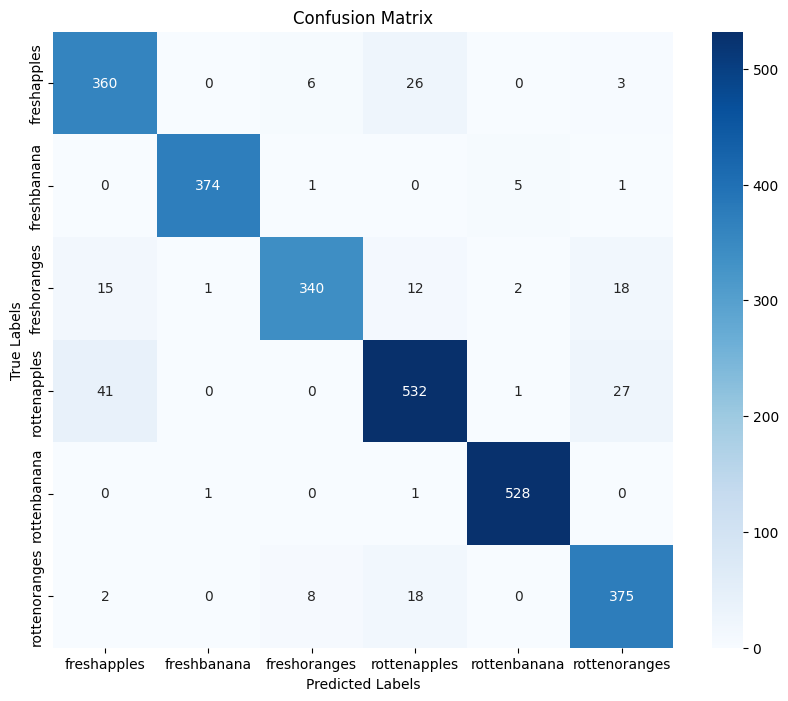

In [ ]:
# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_it.class_indices.keys(), yticklabels=valid_it.class_indices.keys())
plt.title('MobileNet Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Calcular e imprimir el informe de clasificación
class_report = classification_report(y_true, y_pred_classes, target_names=valid_it.class_indices.keys())
print("Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

  freshapples       0.86      0.91      0.89       395
  freshbanana       0.99      0.98      0.99       381
 freshoranges       0.96      0.88      0.92       388
 rottenapples       0.90      0.89      0.89       601
 rottenbanana       0.99      1.00      0.99       530
rottenoranges       0.88      0.93      0.91       403

     accuracy                           0.93      2698
    macro avg       0.93      0.93      0.93      2698
 weighted avg       0.93      0.93      0.93      2698



In [ ]:
import pickle
from google.colab import files

# Guarda el modelo entrenado en un archivo .pkl
with open('modelo_entrenado.pkl', 'wb') as f:
    pickle.dump(model, f)

# Descarga el archivo .pkl desde Google Colab
files.download('modelo_entrenado.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>